# MNIST - Loading, Training and Evaluation

This notebook covers the main stages in Deep Learning, acting as an introduction to both the PyTorch platform as well as some impotant steps when loading data, defining a model, training and evaluation.

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'D:/4ano/2sem/vcpi/pi/util')
import vcpi_util

print(torch.__version__)

2.2.1+cpu


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
transforms = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms,download=True )
test_set = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms,download=True )

In [24]:
print(train_set.classes)
print(train_set.data.shape)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])


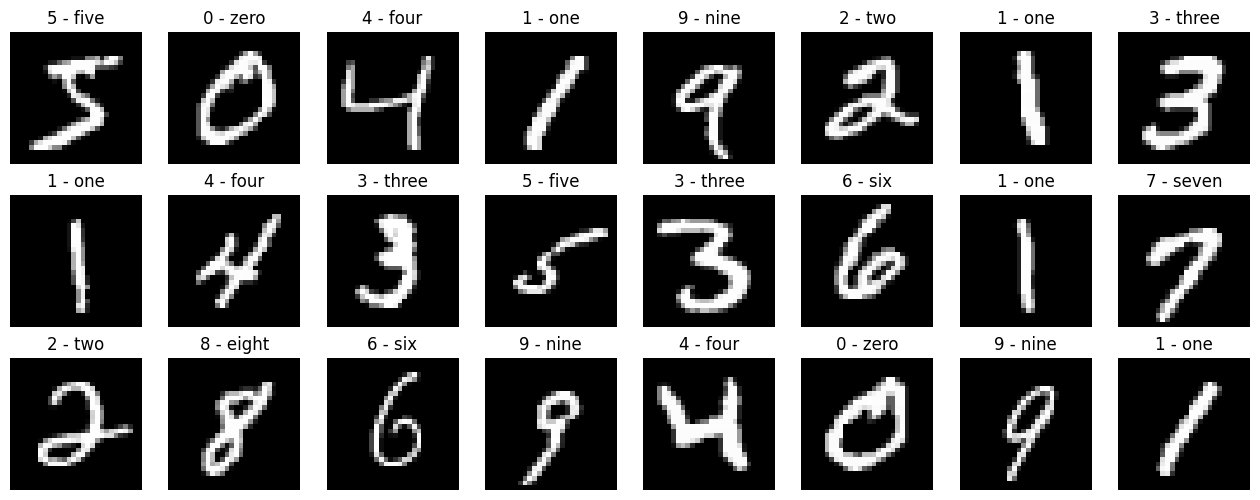

<Figure size 640x480 with 0 Axes>

In [25]:
vcpi_util.show_loaded_images(3,8,train_set,test_set.classes)

In [26]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE, shuffle=False)

In [27]:
print(len(train_loader.dataset))
print(len(train_loader))

60000
469


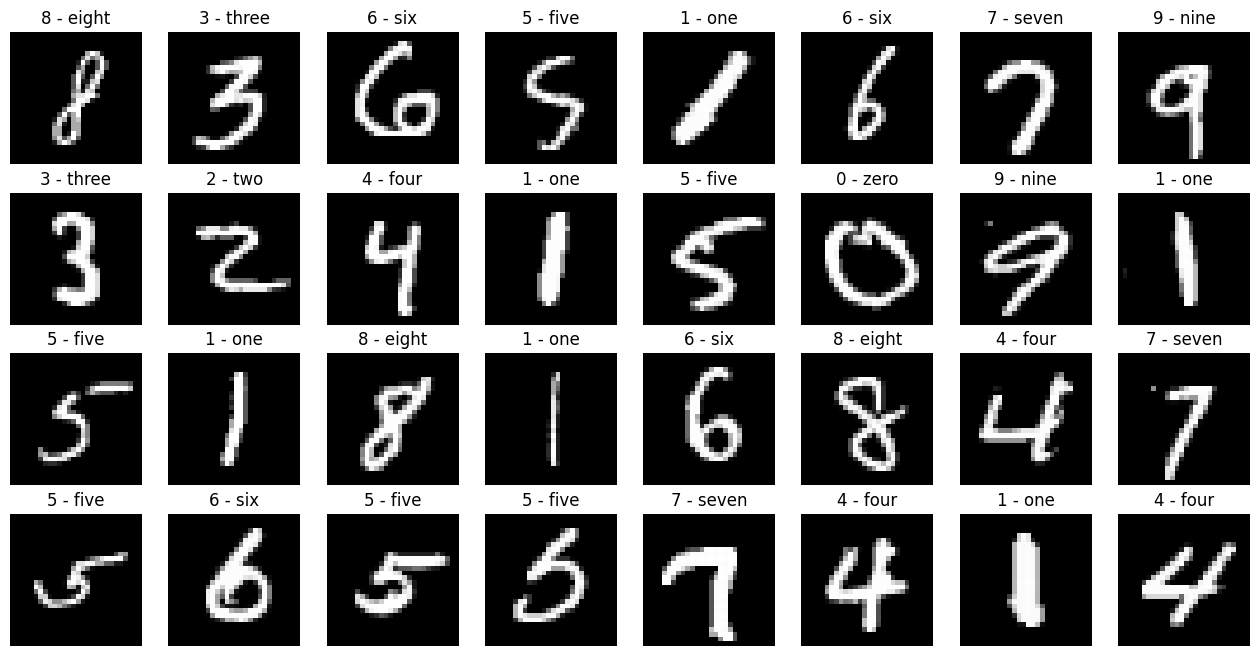

<Figure size 640x480 with 0 Axes>

In [28]:
images,targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,train_set.classes)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


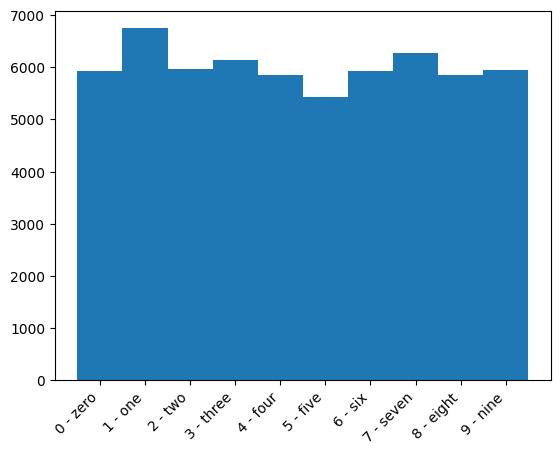

In [29]:
vcpi_util.show_histogram(train_set.targets,train_set.classes)
#Como não há diferenças significativas n é necessário fazer uma melhor distribuição das classes

In [30]:
class FullyConnected_I(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #input de 784 pq as imagens são 28*28 pixeis (28^2 = 784)
        #64 é o numero de neuronios (numero arbitrário)
        self.fc1 = torch.nn.Linear(784,64)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64,10)
        #10 pq temos 10 classes do número 0 a 9
        
    def forward(self,x):
        x=torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [31]:
model = FullyConnected_I()
model.to(device)
print(model)

FullyConnected_I(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [32]:
from torchinfo import summary
summary(model,input_size=(BATCH_SIZE,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_I                         [128, 10]                 --
├─Linear: 1-1                            [128, 64]                 50,240
├─ReLU: 1-2                              [128, 64]                 --
├─Linear: 1-3                            [128, 10]                 650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.51
Input size (MB): 0.40
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.68

In [33]:
images,targets = next(iter(train_loader))

logits = model(images.to(device))

print(logits)

predictions = torch.nn.functional.softmax(logits,dim=1).cpu().detach().numpy()
print(predictions[0])

tensor([[ 0.0886,  0.1138,  0.1300,  ...,  0.1004,  0.0017,  0.1283],
        [ 0.0005,  0.1608, -0.0663,  ..., -0.0542,  0.0424,  0.0678],
        [ 0.0319,  0.0945,  0.0211,  ...,  0.0797,  0.0469,  0.0018],
        ...,
        [ 0.0372,  0.0630, -0.0309,  ..., -0.0309,  0.0637,  0.0487],
        [ 0.0544,  0.1248, -0.0383,  ...,  0.0627, -0.0565,  0.0229],
        [-0.0859,  0.0224, -0.0786,  ...,  0.1030,  0.0902,  0.1846]],
       grad_fn=<AddmmBackward0>)
[0.10547357 0.10817109 0.10994022 0.0966508  0.07500535 0.0796687
 0.11190826 0.10673552 0.09670199 0.10974461]


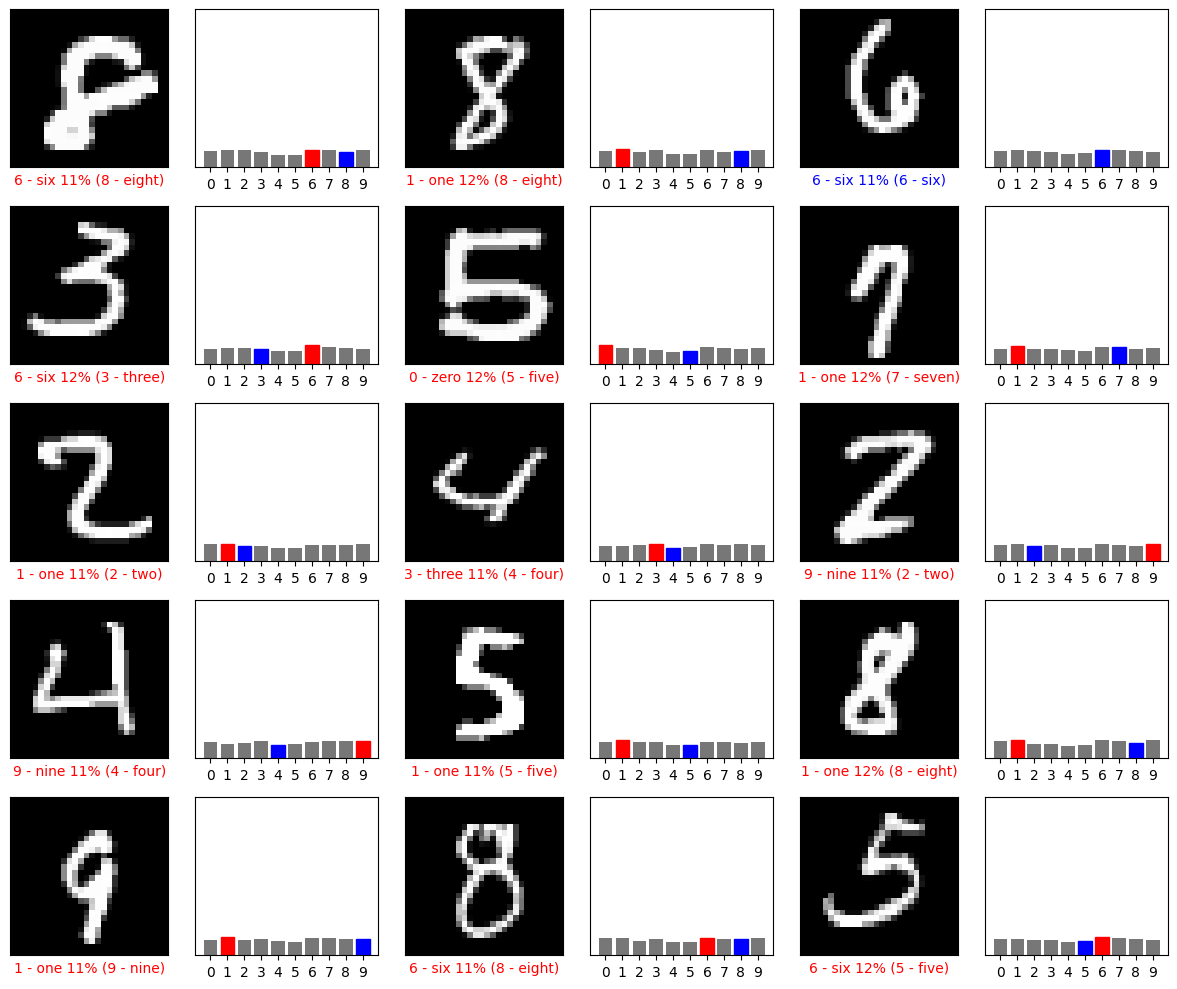

In [34]:
vcpi_util.plot_predictions(images,predictions,targets,train_set.classes,5,3)

In [35]:
def evaluate(model,data_loader):
    model.eval()
    correct = 0
    for images,targets in data_loader:
        output = model(images.to(device))
        _,preds = torch.max(output,dim=1)
        correct += (preds.cpu() == targets).sum()
        
    return (correct/len(data_loader.dataset)).item()

In [36]:
evaluate(model,test_loader)

0.13920000195503235

In [37]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [38]:
def train(model,data_loader,epochs):
    model.train()
    history = {'loss':[],'accuracy':[]}
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0
        for i, (images,targets) in enumerate(data_loader):
            images,targets = images.to(device), targets.to(device)
            output = model(images)
            _,preds = torch.max(output,dim=1)
            loss = loss_fn(output,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (preds == targets).sum()
        accuracy = correct/len(data_loader.dataset)
        stop_time = time.time()
        print(f'Epoch {epoch},  Accuracy: {accuracy:.4f}, Loss: {running_loss:.4f}, Time: {stop_time-start_time:.4f} sec')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history

In [39]:
history = train(model,train_loader,10)

Epoch 0,  Accuracy: 0.8782, Loss: 221.9590, Time: 11.8691 sec
Epoch 1,  Accuracy: 0.9353, Loss: 107.1072, Time: 12.1513 sec
Epoch 2,  Accuracy: 0.9476, Loss: 84.1985, Time: 11.1397 sec
Epoch 3,  Accuracy: 0.9573, Loss: 69.2500, Time: 11.2956 sec
Epoch 4,  Accuracy: 0.9637, Loss: 58.5099, Time: 13.1086 sec
Epoch 5,  Accuracy: 0.9686, Loss: 50.1604, Time: 11.6933 sec
Epoch 6,  Accuracy: 0.9728, Loss: 43.8251, Time: 11.7645 sec
Epoch 7,  Accuracy: 0.9756, Loss: 38.7211, Time: 11.0912 sec
Epoch 8,  Accuracy: 0.9787, Loss: 34.0249, Time: 11.6702 sec
Epoch 9,  Accuracy: 0.9815, Loss: 30.5914, Time: 11.1193 sec


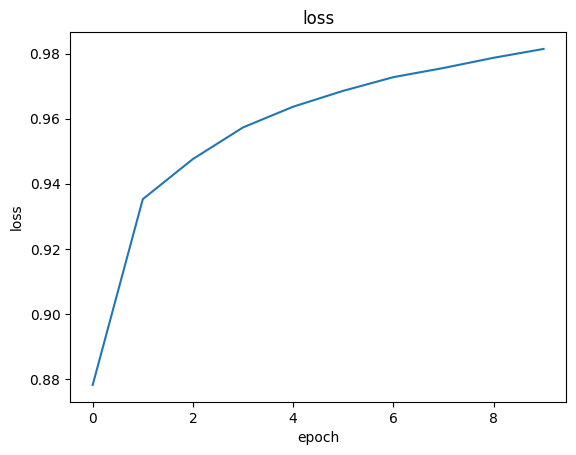

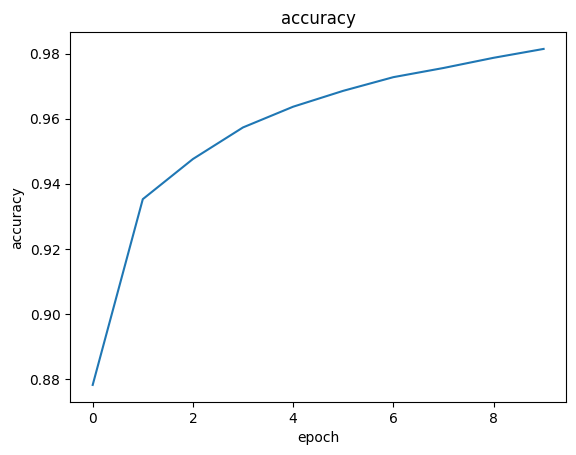

In [40]:
vcpi_util.show_history(history)

In [41]:
evaluate(model,test_loader)

0.9718999862670898

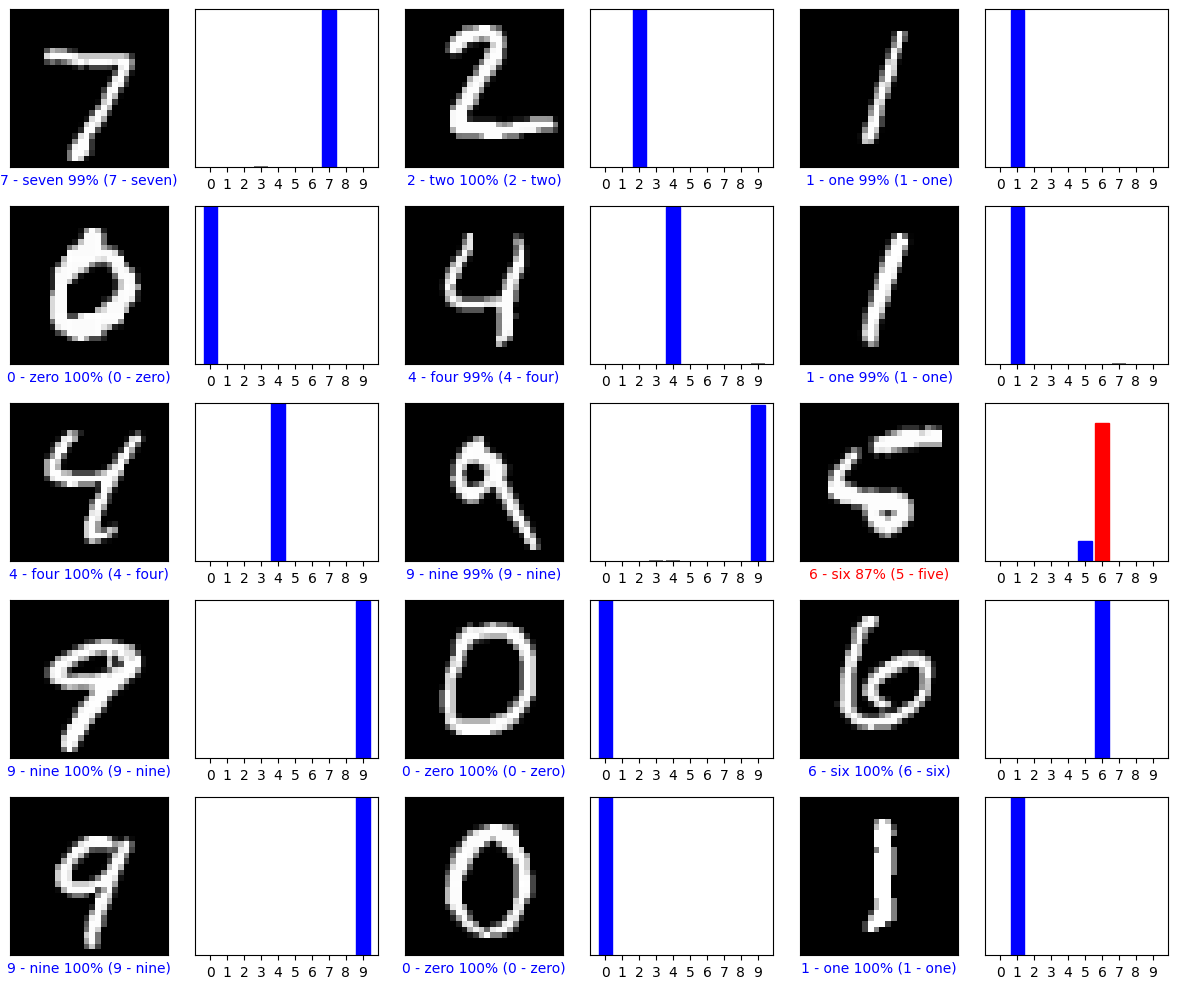

In [42]:
images, targets = next(iter(test_loader))
logits = model(images.to(device))

preds = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, preds, targets, test_set.classes, 5, 3)


In [59]:
k = 0
iters = 0

wrong_preds = []
ground_truth = []
imgs = torch.Tensor(15,1,28,28)

iterator = iter(test_loader)
max_iters = test_set.__len__() / BATCH_SIZE

while k < 15 and iters < max_iters:
    
    images, targets = next(iterator)
    logits = model(images.to(device))
    
    preds = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
    
    for i in range(len(preds)):
        
        if np.argmax(preds[i]) != targets[i] and k < 25:
            wrong_preds.append(preds[i])
            ground_truth.append(targets[i])
            imgs[k, :,:,:] = images[i]
            k+=1
            
    iters += i

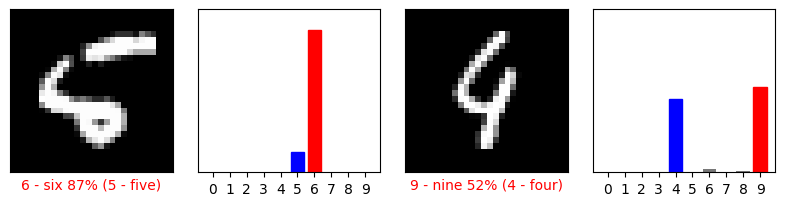

In [60]:
vcpi_util.plot_predictions(imgs,wrong_preds,ground_truth,test_set.classes,5,3)

In [61]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model(images.to(device))
    preds_batch = [np.argmax(x) for x in logits.cpu().detach().numpy()]

    preds.extend(preds_batch)
    ground_truth.extend(targets.cpu().numpy())

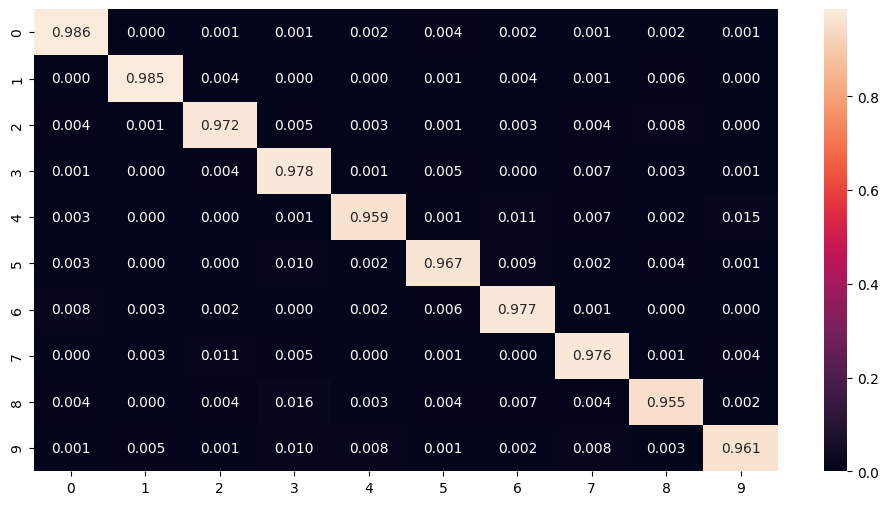

In [62]:
vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.classes))


In [63]:
torch.save({
    'epochs' : 10,
    'model' : model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'history' : history},'D:/4ano/2sem/vcpi/pi/models/model.pt')

In [64]:
retrieved_model = FullyConnected_I()
retrieved_optim = torch.optim.Adam(retrieved_model.parameters())

retrieved = torch.load('D:/4ano/2sem/vcpi/pi/models/model.pt')

In [65]:
retrieved_model.load_state_dict(retrieved['model'])
retrieved_model.to(device)
retrieved_optim.load_state_dict(retrieved['optimizer'])

In [66]:
model_scripted = torch.jit.script(retrieved_model)
model_scripted.save('D:/4ano/2sem/vcpi/pi/models/model_scripted.pt')
model = torch.jit.load('D:/4ano/2sem/vcpi/pi/models/model_scripted.pt')

In [67]:
evaluate(model,test_loader)

0.9718999862670898